In [1]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
from pyextremes import *
from tqdm import tqdm
from seaborn import axes_style
from scipy.stats import rv_continuous
import scipy
import time

# relative import
from EVT_approach import read_df

# supress warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
class ConditionalTailDist(rv_continuous):
    def __init__(self, x_hat, **kwargs):
        super().__init__(a=x_hat, name=f'conditional_tail_dist_{x_hat}', **kwargs)
        self.x_hat = x_hat

    def _pdf(self, x, alpha, beta):
        """PDF for x >= x_hat."""
        x_hat = self.x_hat
        norm_const = np.exp(alpha * x_hat ** beta)
        return alpha * beta * x ** (beta - 1) * np.exp(-alpha * x ** beta) * norm_const

    def _logpdf(self, x, alpha, beta):
        x_hat = self.x_hat
        return (np.log(alpha) + np.log(beta) + (beta - 1) * np.log(x)
                - alpha * x ** beta + alpha * x_hat ** beta)

    def _sf(self, x, alpha, beta):
        """Survival function: P(X >= x | X >= x_hat)."""
        x_hat = self.x_hat
        return np.exp(-alpha * x ** beta + alpha * x_hat ** beta)

    def _logsf(self, x, alpha, beta):
        x_hat = self.x_hat
        return -alpha * x ** beta + alpha * x_hat ** beta


In [3]:
# define series
grid_name = 'nordic'
season = 'spring'
df = read_df(grid_name, season)
series = df['Value']

In [4]:
model = EVA(series)

In [30]:
seasons = ['spring', 'summer', 'autumn', 'winter']
grid_names = ['european', 'nordic', 'uk']
directions = ['right', 'left']
for season in seasons:
    for grid_name in grid_names:
        for direction in directions:

            print(f"Season: {season}, Grid: {grid_name}, Direction: {direction}")
            df = read_df(grid_name, season)
            series = np.abs(50.00 - df['Value'])
            model = EVA(series)
            if direction == 'right':
                extremes_type = 'high'
                if grid_name == 'european':
                    thresholds = np.linspace(0.05, 0.15, 5)
                else:
                    thresholds = np.linspace(0.10, 0.20, 5)
            elif direction == 'left':
                extremes_type = 'high'
                if grid_name == 'european':
                    thresholds = np.linspace(0.05, 0.15, 5)
                else:
                    thresholds = np.linspace(0.10, 0.20, 5)
            else:
                raise ValueError("Direction must be 'right' or 'left'.")
            results = []
            save_path_base = os.path.join(os.getcwd(), "results_EVT_POT", season, grid_name, direction)
            for threshold in thresholds:
                save_path = os.path.join(os.getcwd(), "results_EVT_POT", season, grid_name, direction, str(threshold))
                os.makedirs(save_path, exist_ok=True)

                model.get_extremes("POT", threshold=threshold, r="1s", extremes_type=extremes_type)
                # if there are extremes
                if model.extremes.empty:
                    print(f"No extremes found for threshold {threshold}. Skipping...")
                    continue
                else:
                    try:
                        model.fit_model(model="MLE")
                    except Exception as e:
                        print(f"Error fitting model for threshold {threshold}: {e}")
                        continue
                results.append(model.distribution.mle_parameters | {'threshold': threshold, 'log_likelihood': model.loglikelihood, 'distribution': model.distribution.name})
                try:
                    ks_result = model.test_ks(0.05)
                    # save ks_result to a file
                    ks_file_path = os.path.join(save_path, f"ks_test_result_{threshold}.txt")
                    with open(ks_file_path, 'w') as f:
                        for line in ks_result._repr_body:
                           f.write(line + '\n')
                        f.write(f"distribution: {model.distribution}\n")
                        f.write(f"log_likelihood: {model.loglikelihood}\n")
                    fig, ax = model.plot_diagnostic(alpha=0.95)
                    plt.savefig(os.path.join(save_path, f"diagnostic_plot_{threshold}.png"))
                    plt.close(fig)
                except Exception as e:
                    print(f"Error during KS test or plotting for threshold {threshold}: {e}")
                    continue
            df_results = pd.DataFrame(results)
            df_results.to_csv(os.path.join(save_path_base, f"EVT_results_mle_{grid_name}_{direction}.csv"), index=False)


Season: spring, Grid: european, Direction: right


Number of parameters (k=2) is greater than or equal to the number of samples (n=2) minus one. AIC correction is undefined; returning infinity.
Number of parameters (k=1) is greater than or equal to the number of samples (n=2) minus one. AIC correction is undefined; returning infinity.


Error fitting model for threshold 0.15: invalid type in <class 'NoneType'> for the 'distribution' argument, must be string or scipy.stats.rv_continuous
Season: spring, Grid: european, Direction: left


Number of parameters (k=2) is greater than or equal to the number of samples (n=2) minus one. AIC correction is undefined; returning infinity.
Number of parameters (k=1) is greater than or equal to the number of samples (n=2) minus one. AIC correction is undefined; returning infinity.


Error fitting model for threshold 0.15: invalid type in <class 'NoneType'> for the 'distribution' argument, must be string or scipy.stats.rv_continuous
Season: spring, Grid: nordic, Direction: right
Season: spring, Grid: nordic, Direction: left
Season: spring, Grid: uk, Direction: right
Season: spring, Grid: uk, Direction: left
Season: summer, Grid: european, Direction: right
No extremes found for threshold 0.15. Skipping...
Season: summer, Grid: european, Direction: left
No extremes found for threshold 0.15. Skipping...
Season: summer, Grid: nordic, Direction: right
File Taajuusdata2024-06-05.csv contains values below 40.0
Season: summer, Grid: nordic, Direction: left
File Taajuusdata2024-06-05.csv contains values below 40.0
Season: summer, Grid: uk, Direction: right
Season: summer, Grid: uk, Direction: left
Season: autumn, Grid: european, Direction: right


Number of parameters (k=2) is greater than or equal to the number of samples (n=3) minus one. AIC correction is undefined; returning infinity.


Season: autumn, Grid: european, Direction: left


Number of parameters (k=2) is greater than or equal to the number of samples (n=3) minus one. AIC correction is undefined; returning infinity.


Season: autumn, Grid: nordic, Direction: right
Season: autumn, Grid: nordic, Direction: left
Season: autumn, Grid: uk, Direction: right
Season: autumn, Grid: uk, Direction: left
Season: winter, Grid: european, Direction: right
No extremes found for threshold 0.15. Skipping...
Season: winter, Grid: european, Direction: left
No extremes found for threshold 0.15. Skipping...
Season: winter, Grid: nordic, Direction: right
File Taajuusdata2024-12-07.csv contains values below 40.0
File Taajuusdata2024-12-04.csv contains values below 40.0
File Taajuusdata2024-12-10.csv contains values below 40.0
File Taajuusdata2024-12-05.csv contains values below 40.0
File Taajuusdata2024-12-01.csv contains values below 40.0
File Taajuusdata2024-12-03.csv contains values below 40.0
Season: winter, Grid: nordic, Direction: left
File Taajuusdata2024-12-07.csv contains values below 40.0
File Taajuusdata2024-12-04.csv contains values below 40.0
File Taajuusdata2024-12-10.csv contains values below 40.0
File Taaju

In [31]:
seasons = ['spring', 'summer', 'autumn', 'winter']
grid_names = ['european', 'nordic', 'uk']
directions = ['right', 'left']
for season in seasons:
    for grid_name in grid_names:
        for direction in directions:

            print(f"Season: {season}, Grid: {grid_name}, Direction: {direction}")
            df = read_df(grid_name, season)
            series = df['Value']
            model = EVA(series)
            if direction == 'right':
                extremes_type = 'high'
            elif direction == 'left':
                extremes_type = 'high'
            else:
                raise ValueError("Direction must be 'right' or 'left'.")
            block_sizes = ["10m", "1h"]
            results = []
            save_path_base = os.path.join(os.getcwd(), "results_EVT_BM", season, grid_name, direction)
            for block_size in block_sizes:
                save_path = os.path.join(os.getcwd(), "results_EVT_BM", season, grid_name, direction, block_size)
                os.makedirs(save_path, exist_ok=True)

                model.get_extremes("BM", block_size=block_size, errors='ignore', extremes_type=extremes_type)
                # if there are extremes
                if model.extremes.empty:
                    print(f"No extremes found for block size {block_size}. Skipping...")
                    continue
                else:
                    try:
                        model.fit_model(model="MLE")
                    except Exception as e:
                        print(f"Error fitting model for block size {block_size}: {e}")
                        continue
                results.append(model.distribution.mle_parameters | {'block_size': block_size, 'log_likelihood': model.loglikelihood, 'distribution': model.distribution.name})
                try:
                    ks_result = model.test_ks(0.05)
                    # save ks_result to a file
                    ks_file_path = os.path.join(save_path, f"ks_test_result_{block_size}.txt")
                    with open(ks_file_path, 'w') as f:
                        for line in ks_result._repr_body:
                           f.write(line + '\n')
                        f.write(f"distribution: {model.distribution}\n")
                        f.write(f"log_likelihood: {model.loglikelihood}\n")
                    fig, ax = model.plot_diagnostic(alpha=0.95)
                    plt.savefig(os.path.join(save_path, f"diagnostic_plot_{block_size}.png"))
                    plt.close(fig)
                except Exception as e:
                    print(f"Error during KS test or plotting for block size {block_size}: {e}")
                    continue
            df_results = pd.DataFrame(results)
            df_results.to_csv(os.path.join(save_path_base, f"EVT_results_mle_{grid_name}_{direction}.csv"), index=False)


Season: spring, Grid: european, Direction: right
Season: spring, Grid: european, Direction: left
Season: spring, Grid: nordic, Direction: right
Season: spring, Grid: nordic, Direction: left
Season: spring, Grid: uk, Direction: right
Season: spring, Grid: uk, Direction: left
Season: summer, Grid: european, Direction: right
Season: summer, Grid: european, Direction: left
Season: summer, Grid: nordic, Direction: right
File Taajuusdata2024-06-05.csv contains values below 40.0
Season: summer, Grid: nordic, Direction: left
File Taajuusdata2024-06-05.csv contains values below 40.0
Season: summer, Grid: uk, Direction: right
Season: summer, Grid: uk, Direction: left
Season: autumn, Grid: european, Direction: right
Season: autumn, Grid: european, Direction: left
Season: autumn, Grid: nordic, Direction: right
Season: autumn, Grid: nordic, Direction: left
Season: autumn, Grid: uk, Direction: right
Season: autumn, Grid: uk, Direction: left
Season: winter, Grid: european, Direction: right
Season: wi

In [13]:
# model.get_extremes("POT", threshold=50.10, r="1s")
t1 = time.time()
model.get_extremes("BM", block_size="10m", errors='ignore')
t2 = time.time()
print(f"Time taken to get extremes of interval: {t2 - t1:.4f} seconds")

Time taken to get extremes of 1D interval: 0.1132 seconds


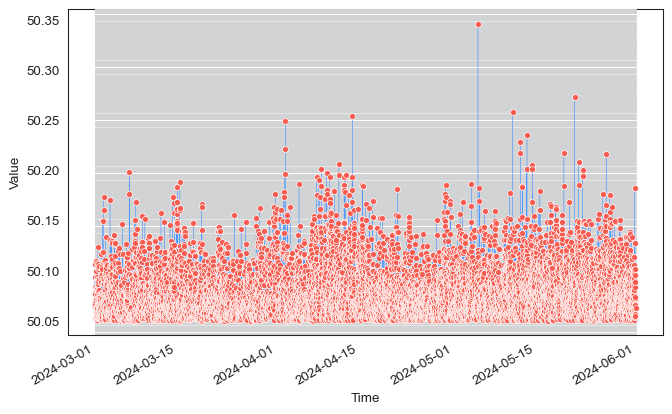

In [14]:
model.plot_extremes()
plt.show()

In [5]:
# # some base settings
# thresholds = np.linspace(50.1, 50.25, 100)
# conditional_tail_dist_list = [ConditionalTailDist(x_hat=thresholds[i]) for i in range(len(thresholds[:1]))]
# distributions = ["genpareto","expon"] + conditional_tail_dist_list
# print(distributions)
# for distribution in distributions:
#     # Get distribution name
#         if isinstance(distribution, str):
#             distribution_name = distribution
#             print(distribution_name)
#         elif isinstance(distribution, scipy.stats.rv_continuous):
#             distribution_name = getattr(distribution, "name", None)
#             print(distribution_name)
#         else:
#             raise TypeError(
#                 f"invalid type in {type(distribution)} "
#                 f"for the 'distribution' argument, "
#                 f"must be string or scipy.stats.rv_continuous"
#             )

In [6]:
# from my_distributions import ConditionalTailDist
# thresholds = np.linspace(50.1, 50.25, 100)
# conditional_tail_dist_list = [ConditionalTailDist(x_hat=thresholds[i]) for i in range(len(thresholds[:1]))]
# distributions = ["genpareto","expon"] + conditional_tail_dist_list
# print(distributions)
# for distribution in distributions:
#     # Get distribution name
#         if isinstance(distribution, str):
#             distribution_name = distribution
#             print(distribution_name)
#         elif isinstance(distribution, scipy.stats.rv_continuous):
#             distribution_name = getattr(distribution, "name", None)
#             print(distribution_name)
#         else:
#             raise TypeError(
#                 f"invalid type in {type(distribution)} "
#                 f"for the 'distribution' argument, "
#                 f"must be string or scipy.stats.rv_continuous"
#             )

In [7]:
# distributions = [ConditionalTailDist(x_hat=x_hat) for x_hat in [0.1, 50.1]]
# extremes = model.extremes
# for distribution in distributions:
#     pdf = distribution._pdf(extremes, alpha=0.1, beta=2)
#     sf = distribution._sf(extremes, alpha=0.1, beta=2)
#     # plt.scatter(extremes, pdf, label='pdf_' + distribution.name)
#     plt.scatter(extremes, sf, label='sf_' + distribution.name)
# plt.legend()
# plt.show()

In [8]:
# # Visualizations
#
# ax_mean_res = plt.figure().gca()
# plot_mean_residual_life(ts=series, thresholds=thresholds, extremes_type='high', ax=ax_mean_res)
# seconds_in_series = len(series)
# ax_full = plot_threshold_stability(
#     series,
#     return_period=seconds_in_series,
#     return_period_size='1s',
#     thresholds=thresholds,
#     distributions=distributions,
# )
# plt.show()

In [8]:
# extremes = get_extremes(
#     ts=series,
#     method="POT",
#     threshold=50.18,
#     r="1s"
# )

# return_periods = get_return_periods(
#     ts=series,
#     extremes=extremes,
#     extremes_method="POT",
#     extremes_type="high",
#     # block_size="365.2425D",
#     return_period_size="1D",
#     plotting_position="weibull",
# )
#
# return_periods.sort_values("return period", ascending=False).head()

In [20]:
model.fit_model(model="MLE")

In [25]:
print(model.distribution)
print(model.loglikelihood)
print(model.distribution.mle_parameters)

      pyextremes distribution       
------------------------------------
name: genpareto                     
free parameters: c, scale           
fixed parameters: floc=49.800       
MLE parameters: c=3.730, scale=0.000
------------------------------------
-inf
{'c': np.float64(3.730429742749158), 'scale': np.float64(4.24664549209433e-27)}
genpareto


In [22]:
# test KS
model.test_ks(0.05)

                      Kolmogorov-Smirnov Test                      
-------------------------------------------------------------------
Null hypothesis: data follows genextreme distribution              
Alternative hypothesis: data doesn't follow genextreme distribution
                                                                   
Test statistic: D = 0.034943234174209636                           
p-value: 7.263620555734375e-10                                     
                                                                   
Significance level: 0.05                                           
Critical value: 0.014385862499659887                               
Critical region: reject null-hypothesis if D > 0.014385862499659887
                                                                   
Test result: data doesn't follow genextreme distribution           
-------------------------------------------------------------------

In [23]:
summary = model.get_summary(
    return_period=[1, 2, 5, 10, 25, 50, 100, 250, 500, 1000],
    return_period_size="1D",
    alpha=0.95,
    n_samples=1000,
)
print(summary)

               return value   lower ci   upper ci
return period                                    
1.0               50.217820  50.209636  50.225865
2.0               50.256239  50.244187  50.268714
5.0               50.317511  50.297834  50.337985
10.0              50.373372  50.345840  50.402041
25.0              50.462538  50.421339  50.506352
50.0              50.543860  50.488676  50.603178
100.0             50.639468  50.567151  50.718718
250.0             50.792107  50.689396  50.906857
500.0             50.931331  50.798047  51.081524
1000.0            51.095018  50.923588  51.290063


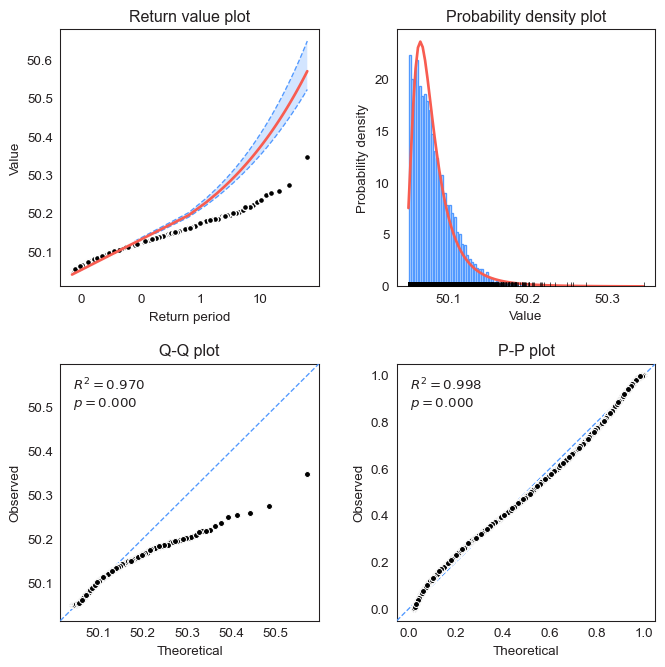

In [24]:
fig, ax = model.plot_diagnostic(alpha=0.95, return_period_size="1D")
plt.show()